# Part 1 – Aim: ANN from Scratch

## Original code from “Implementing a Multi-layer Artificial Neural Network from Scratch” chapter 11 by Raschka et al. (2022)

In [44]:
# Obtaining and preparing the MNIST dataset
from sklearn.datasets import fetch_openml

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [45]:
# Normalizing to [-1, 1] range
X = ((X / 255.0) - 0.5) * 2 

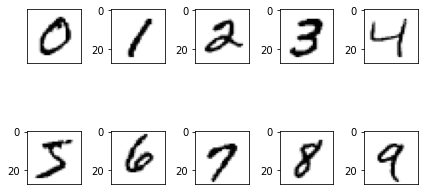

In [46]:
# Visualizing the first digit of each class
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=False)
ax = ax.flatten()

for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

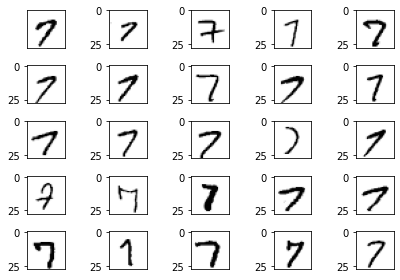

In [47]:
# Visualizing 25 different versions of "7"
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=False)
ax = ax.flatten()

for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [48]:
# Splitting into training,
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.1, random_state=123, stratify=y_temp)

del X_temp, y_temp, X, y

In [49]:
import numpy as np

$sigmoid - \sigma(z) = \frac{1}{1 + e^{-z}}$

In [50]:
##########################
### MODEL
##########################

def softmax(x, mini_batch):
    for i in range(0, mini_batch):
        x[i] = np.exp(x[i]) / np.sum(np.exp(x[i]))
    return x

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z)) 

def int_to_onehot(y, num_labels):
    
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1
        
    return ary

class NeuralNetMLP_book:
    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()

        self.num_classes = num_classes

        rng = np.random.RandomState(random_seed)

        # hidden layer
        self.weight_h = rng.normal(loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)

        # output layer
        self.weight_out = rng.normal(loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes) 
    
    def forward(self, x):
    
        # hidden layer
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # output layer
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)

        return a_h,- a_out
    
    
    def backward(self, x, a_h, a_out, y):
        
        #########################
        ### Output layer weights
        #########################
        
        # one-hot encoding
        y_onehot = int_to_onehot(y, self.num_classes)
        
        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        
        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.0 * (a_out - y_onehot) / y.shape[0]
        
        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1.0 - a_out) # sigmoid derivative
        
        # output dim: [n_examples, n_classes]        
        delta_out = d_loss__d_a_out * d_a_out__d_z_out
        
        # gradient for output weights
        
        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h
        
        # input dim: [n_classes, n_examples]
        # dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        
        
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet
        # * dHiddenNet/dWeight
        
        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
        
        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1.0 - a_h) # sigmoid derivative
        
        # [n_examples, n_features]
        d_z_h__d_w_h = x
        
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)
        return (d_loss__dw_out, d_loss__db_out, d_loss__d_w_h, d_loss__d_b_h)

In [51]:
model = NeuralNetMLP(num_features=28*28, num_hidden=150, num_classes=10)

In [52]:
num_epochs = 20
minibatch_size = 100

def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        
        yield X[batch_idx], y[batch_idx]

# iterate over training epochs
for i in range(num_epochs):
    # iterate over minibatches
    minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
    for X_train_mini, y_train_mini in minibatch_gen:
        break
    break
print(minibatch_gen)
print(X_train_mini.shape)
print(y_train_mini.shape)

<generator object minibatch_generator at 0x0000021583800350>
(100, 784)
(100,)


In [53]:
def mse_loss(targets, probas, num_labels=10):
    one_hot_targets = int_to_onehot(targets, num_labels=num_labels)
    
    return np.mean((one_hot_targets - probas) ** 2)

def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)

In [54]:
_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)

print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.2
Initial validation accuracy: 13.0%


In [55]:
from sklearn.metrics import roc_auc_score

In [57]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0.0, 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
    for i, (features, targets) in enumerate(minibatch_gen):
        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas) ** 2)
        correct_pred += (predicted_labels == targets).sum()
        num_examples += targets.shape[0]
        mse += loss
    mse = mse / i
    acc = correct_pred / num_examples
    pred = softmax(probas, minibatch_size)
    AUC = roc_auc_score(targets, pred, multi_class='ovo')
    return mse, acc, AUC

In [58]:
mse, acc, AUC = compute_mse_and_acc(model, X_valid, y_valid)

print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')
print(f'Initial AUC: {AUC*100:.1f}%')

Initial validation MSE: 0.2
Initial validation accuracy: 13.0%
Initial AUC: 49.0%


In [59]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs, learning_rate=0.1):
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    epoch_train_AUC = []
    epoch_valid_AUC = []
    
    for e in range(num_epochs):
        # iterate over minibatches
        minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
        
        for X_train_mini, y_train_mini in minibatch_gen:
            
            ### Compute outputs ###
            a_h, a_out = model.forward(X_train_mini)
            
            ### Compute gradients ###
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = model.backward(X_train_mini, a_h, a_out, y_train_mini)
            
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
            
        #### Epoch Logging ####
        train_mse, train_acc, train_AUC = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc, valid_AUC = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        epoch_train_AUC.append(train_AUC)
        epoch_valid_AUC.append(valid_AUC)
       
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} 'f'| Train MSE: {train_mse:.2f} 'f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%',  f'| Train AUC: {train_AUC:.4f}%',  f'| Valid AUC: {valid_AUC:.4f}%')
        
    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [60]:
np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_valid_acc = train(model, X_train, y_train, X_valid, y_valid,
                                                     num_epochs=20, learning_rate=0.4)

Epoch: 001/020 | Train MSE: 0.02 | Train Acc: 88.67% | Valid Acc: 88.20% | Train AUC: 0.9907% | Valid AUC: 0.9851%
Epoch: 002/020 | Train MSE: 0.02 | Train Acc: 91.17% | Valid Acc: 90.90% | Train AUC: 0.9973% | Valid AUC: 0.9917%
Epoch: 003/020 | Train MSE: 0.01 | Train Acc: 92.38% | Valid Acc: 91.96% | Train AUC: 0.9946% | Valid AUC: 0.9916%
Epoch: 004/020 | Train MSE: 0.01 | Train Acc: 93.02% | Valid Acc: 92.51% | Train AUC: 0.9943% | Valid AUC: 0.9872%
Epoch: 005/020 | Train MSE: 0.01 | Train Acc: 93.80% | Valid Acc: 93.12% | Train AUC: 0.9981% | Valid AUC: 0.9990%
Epoch: 006/020 | Train MSE: 0.01 | Train Acc: 94.28% | Valid Acc: 93.61% | Train AUC: 0.9980% | Valid AUC: 0.9979%
Epoch: 007/020 | Train MSE: 0.01 | Train Acc: 94.78% | Valid Acc: 94.27% | Train AUC: 0.9996% | Valid AUC: 0.9989%
Epoch: 008/020 | Train MSE: 0.01 | Train Acc: 95.03% | Valid Acc: 94.49% | Train AUC: 0.9996% | Valid AUC: 0.9957%
Epoch: 009/020 | Train MSE: 0.01 | Train Acc: 95.28% | Valid Acc: 94.63% | Train

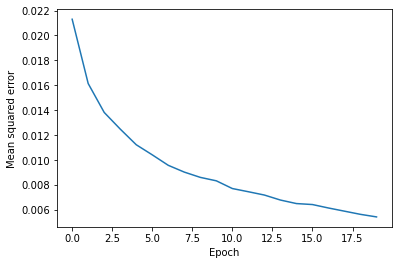

In [61]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
plt.show()

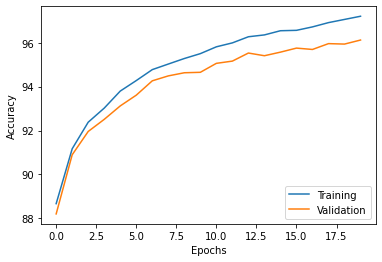

In [62]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc, label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc, label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

In [65]:
test_mse, test_acc, test_AUC = compute_mse_and_acc(model, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')
print(f'AUC: {test_AUC:.4f}')

Test accuracy: 96.07%
AUC: 0.9995


In [66]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

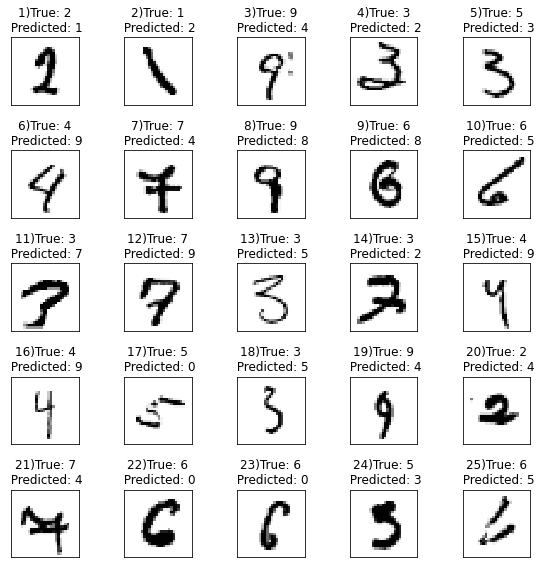

In [67]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1})'
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11.09.png', dpi=300)
plt.show()

In [ ]:
class NeuralNetMLP:
    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()

        self.num_classes = num_classes

        rng = np.random.RandomState(random_seed)

        # hidden layer 1
        self.weight_h1 = rng.normal(loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h1 = np.zeros(num_hidden)
        
        # hidden layer 2
        self.weight_h2 = rng.normal(loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h2 = np.zeros(num_hidden)

        # output layer
        self.weight_out = rng.normal(loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes) 
    
    def forward(self, x):
    
        # hidden layer 1
        z_h1 = np.dot(x, self.weight_h1.T) + self.bias_h1
        a_h1 = sigmoid(z_h1)

        # hidden layer 2
        z_h2 = np.dot(a_h1, self.weight_h2.T) + self.bias_h2
        a_h2 = sigmoid(z_h2)
        
        # output layer
        z_out = np.dot(a_h2, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)

        return a_h1, a_h2, a_out
    
    
    def backward(self, x, a_h1, a_h2, a_out, y):
        
        #########################
        ### Output layer weights
        #########################
        
        # one-hot encoding
        y_onehot = int_to_onehot(y, self.num_classes)
        
        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        
        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.0 * (a_out - y_onehot) / y.shape[0]
        
        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1.0 - a_out) # sigmoid derivative
        
        # output dim: [n_examples, n_classes]        
        delta_out = d_loss__d_a_out * d_a_out__d_z_out
        
        # gradient for output weights
        
        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h
        
        # input dim: [n_classes, n_examples]
        # dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        
        
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet
        # * dHiddenNet/dWeight
        
        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
        
        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative
        
        # [n_examples, n_features]
        d_z_h__d_w_h = x
        
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)
        return (d_loss__dw_out, d_loss__db_out, d_loss__d_w_h, d_loss__d_b_h)

## Implemeting 2 hidden layers 

In [99]:
def compute_mse_and_acc_ours(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0.0, 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
    for i, (features, targets) in enumerate(minibatch_gen):
        _,_, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas) ** 2)
        correct_pred += (predicted_labels == targets).sum()
        num_examples += targets.shape[0]
        mse += loss
    mse = mse / i
    acc = correct_pred / num_examples
    pred = softmax(probas, minibatch_size)
    AUC = roc_auc_score(targets, pred, multi_class='ovo')
    return mse, acc, AUC

In [100]:
class NeuralNetMLP_ours:
    
    def __init__(self,num_features, num_hidden, num_classes, random_seed = 123):
        super().__init__()
        
        self.num_classes = num_classes
        
        #hidden
        rng = np.random.RandomState(random_seed)
        
        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)
        #### my w ####
       
        self.weight_h1 = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_hidden))
        self.bias_h1 = np.zeros(num_hidden)
        ######
        #output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)
        ##### my forward ####
        z_h1 = np.dot(a_h, self.weight_h1.T) + self.bias_h1  ## + bias ????
        a_h1 = sigmoid(z_h1)
    
        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h1, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_h1, a_out
    
    def backward(self, x, a_h, a_h1, a_out, y):  

        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)
    
        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        
        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]
    
        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative
    
        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"
    
        # gradient for output weights
        
        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h1
        
        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        
    
        #################################        
        # Part 2: dLoss/dHidden1Weights
        ## = DeltaOut * dOutNet/dHidden1Act * dHidden1Act/dHidden1Net * dHidden1Net/dWeight1
        
        # [n_classes, n_hidden]
        d_z_out__a_h1 = self.weight_out
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h1 = np.dot(delta_out, d_z_out__a_h1)
        
        # [n_examples, n_hidden]
        d_a_h1__d_z_h1 = a_h1 * (1. - a_h1) # sigmoid derivative
        
        # [n_examples, n_hiden]
        d_z_h1__d_w_h1 = a_h
        
        # output dim: [n_hidden, n_hiden]
        d_loss__d_w_h1 = np.dot((d_loss__a_h1 * d_a_h1__d_z_h1).T, d_z_h1__d_w_h1)
        d_loss__d_b_h1 = np.sum((d_loss__a_h1 * d_a_h1__d_z_h1), axis=0)
        
        # Part 3: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHidden1Act * dHidden1Act/dHidden1Net * dHidden1Net/dHiddenAct*dHiddenAct/dHiddenNet*dHiddenNet/dWeight
        #[hiden,hiden]
        d_z_h1__a_h = self.weight_h1
        #[exam,hiden]
        d_a_h__d_z_h = a_h * (1. - a_h)
        #[exam,features]
        d_z_h__d_w_h = x
        aa = np.dot(d_loss__a_h1 * d_a_h1__d_z_h1,d_z_h1__a_h)
        d_loss__d_w_h = np.dot((aa*d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((aa*d_a_h__d_z_h), axis=0)
    
        return (d_loss__dw_out, d_loss__db_out, 
                d_loss__d_w_h1, d_loss__d_w_h, d_loss__d_b_h1, d_loss__d_b_h)

In our class *NeuralNetMLP_ours* we compute the derivatives of $2$ hidden layers, with the same procedure done in the book. The following derivatives weights for the first hidden layer representing below:

\begin{align}
        \frac{\partial L}{\partial w^h} = \frac{\partial L}{\partial a^{out}}⋅\frac{\partial a^{out}}{\partial z^{out}}⋅\frac{\partial z^{out}}{\partial a^{h1}}\cdot\frac{\partial a^{h1}}{\partial z^{h1}}⋅\frac{\partial z^{h1}}{\partial a^{h}}⋅\frac{\partial a^{h}}{\partial z^{h}}⋅\frac{\partial z^{h}}{\partial w^{h}}
    \end{align}

In [101]:
model_ours = NeuralNetMLP_ours(num_features=28*28, num_hidden=150, num_classes=10)

In [102]:
def train_ours(model, X_train, y_train, X_valid, y_valid, num_epochs, learning_rate=0.001):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    epoch_train_AUC = []
    epoch_valid_AUC = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            a_h, a_h1, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h1, d_loss__d_w_h, d_loss__d_b_h1, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_h1, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.weight_h1 -= learning_rate * d_loss__d_w_h1
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.bias_h1 -= learning_rate * d_loss__d_b_h1
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        
        #### Epoch Logging ####
        train_mse, train_acc, train_AUC = compute_mse_and_acc_ours(model, X_train, y_train)
        valid_mse, valid_acc, valid_AUC = compute_mse_and_acc_ours(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        epoch_train_AUC.append(train_AUC)
        epoch_valid_AUC.append(valid_AUC)
       
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} 'f'| Train MSE: {train_mse:.2f} 'f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%',  f'| Train AUC: {train_AUC:.4f}%',  f'| Valid AUC: {valid_AUC:.4f}%')
        
    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [103]:
epoch_loss, epoch_train_acc, epoch_valid_acc = train_ours(model_ours, X_train, y_train, X_valid, y_valid,
                                                     num_epochs=20, learning_rate=0.4)

Epoch: 001/020 | Train MSE: 0.03 | Train Acc: 84.11% | Valid Acc: 84.08% | Train AUC: 0.9848% | Valid AUC: 0.9766%
Epoch: 002/020 | Train MSE: 0.02 | Train Acc: 89.67% | Valid Acc: 89.43% | Train AUC: 0.9729% | Valid AUC: 0.9908%
Epoch: 003/020 | Train MSE: 0.02 | Train Acc: 91.39% | Valid Acc: 91.35% | Train AUC: 0.9974% | Valid AUC: 0.9978%
Epoch: 004/020 | Train MSE: 0.01 | Train Acc: 92.37% | Valid Acc: 92.10% | Train AUC: 0.9837% | Valid AUC: 0.9928%
Epoch: 005/020 | Train MSE: 0.01 | Train Acc: 93.02% | Valid Acc: 92.67% | Train AUC: 0.9989% | Valid AUC: 0.9952%
Epoch: 006/020 | Train MSE: 0.01 | Train Acc: 93.74% | Valid Acc: 93.27% | Train AUC: 0.9929% | Valid AUC: 0.9948%
Epoch: 007/020 | Train MSE: 0.01 | Train Acc: 94.20% | Valid Acc: 93.55% | Train AUC: 0.9823% | Valid AUC: 0.9976%
Epoch: 008/020 | Train MSE: 0.01 | Train Acc: 94.71% | Valid Acc: 93.90% | Train AUC: 0.9974% | Valid AUC: 0.9957%
Epoch: 009/020 | Train MSE: 0.01 | Train Acc: 94.66% | Valid Acc: 93.96% | Train

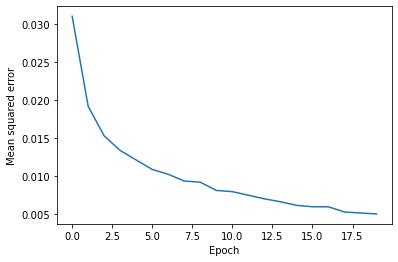

In [107]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
plt.show()

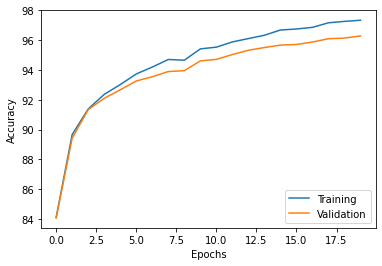

In [108]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc, label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc, label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

In [104]:
test_mse, test_acc, test_AUC = compute_mse_and_acc_ours(model_ours, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')
print(f'AUC: {test_AUC:.4f}')

Test accuracy: 96.12%
AUC: 0.9988


In [105]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_,_, probas = model_ours.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

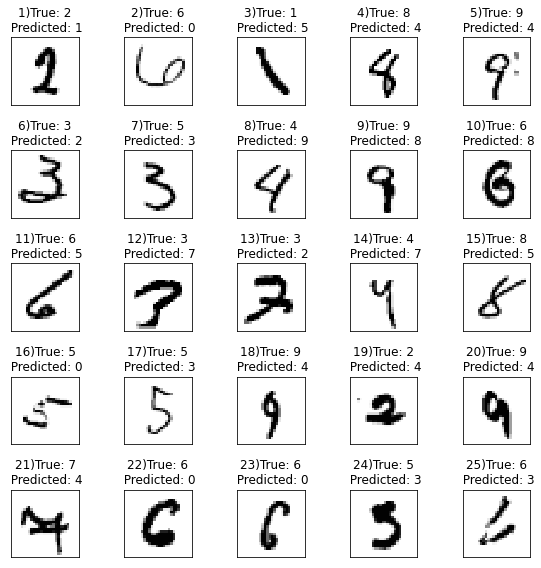

In [106]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1})'
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11.09.png', dpi=300)
plt.show()

## Comparison 1 hidden layer (from the book) to 2 hidden layers (ours) and 2 hidden layers (Keras)

In [8]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
import keras

# Configuration options
feature_vector_length = 784
num_classes = 10
n_hiden = 150
# Load the data

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123, stratify=y)

# Reshape the data - MLPs do not understand such things as '2D'.
# Reshape to 28 x 28 pixels = 784 features
X_train = X_train.reshape(X_train.shape[0], feature_vector_length)
X_test = X_test.reshape(X_test.shape[0], feature_vector_length)

# Convert into greyscale
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = ((X_train/255.0) - 0.5)*2
X_test = ((X_test/255.0) - 0.5)*2

# Convert target classes to categorical ones
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Set the input shape
input_shape = (feature_vector_length,)
print(f'Feature shape: {input_shape}')

# Create the model
model = Sequential()
model.add(Dense(n_hiden,input_shape=input_shape, activation='sigmoid'))
model.add(Dense(n_hiden, activation='sigmoid'))
model.add(Dense(num_classes, activation='sigmoid'))

# Configure the model and start training
optimizer = keras.optimizers.SGD(learning_rate=0.4)
model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy','AUC'])
model.fit(X_train, y_train, epochs=20, batch_size=100, verbose=1, validation_split=0.1)

Feature shape: (784,)
Epoch 1/20
441/441 [==============================] - 2s 3ms/step - loss: 0.0911 - accuracy: 0.2197 - auc: 0.6407 - val_loss: 0.0878 - val_accuracy: 0.4218 - val_auc: 0.7543
Epoch 2/20
441/441 [==============================] - 1s 2ms/step - loss: 0.0858 - accuracy: 0.3623 - auc: 0.7787 - val_loss: 0.0833 - val_accuracy: 0.3914 - val_auc: 0.8359
Epoch 3/20
441/441 [==============================] - 1s 2ms/step - loss: 0.0784 - accuracy: 0.4573 - auc: 0.8543 - val_loss: 0.0731 - val_accuracy: 0.5298 - val_auc: 0.8945
Epoch 4/20
441/441 [==============================] - 1s 2ms/step - loss: 0.0672 - accuracy: 0.5996 - auc: 0.9100 - val_loss: 0.0619 - val_accuracy: 0.6537 - val_auc: 0.9280
Epoch 5/20
441/441 [==============================] - 1s 2ms/step - loss: 0.0567 - accuracy: 0.6920 - auc: 0.9391 - val_loss: 0.0522 - val_accuracy: 0.7143 - val_auc: 0.9485
Epoch 6/20
441/441 [==============================] - 1s 2ms/step - loss: 0.0482 - accuracy: 0.7518 - auc: 0

In [9]:
# Test the model after training
test_results = model.evaluate(X_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]:.2f} - Accuracy: {test_results[1]:.2f}% - AUC: {test_results[2]:.4f}')

657/657 [==============================] - 1s 1ms/step - loss: 0.0182 - accuracy: 0.9028 - auc: 0.9854
Test results - Loss: 0.02 - Accuracy: 0.90% - AUC: 0.9854


## part 4 - Comparison predictive performance ##

In this part, we implemented a fully connected ANN with 2 hidden layers with the Keras library. We chose the loss function 'MSE' and the criterion 'SGD'. The hyperparameters (learning rate, batch size, and the number of epochs) are set to the same values as the previous sections. To make a comparison with the net that we implement from scratch.
It can be observed that the 2 hidden layers performance that we implemented from scratch was a little better than 1 hidden layer.
On the other hand, the performance observed using Keras library with 2 hidden layers was worse than the implementation from scratch.

In the table below you can see the results for the models:



In [15]:
import pandas as pd
print('0 -Test result one hidden layer from scratch')
print('1 -Test result two hidden layer from scratch')
print('2 -Test result two hidden layer keras')
table_dict = {'Loss':[0.01, 0.005, 0.02],
              'Accuracy[%]': [96.07, 96.12, 90.00],
              'AUC': [0.9995, 0.9988,0.9854]}
pd.DataFrame.from_dict(table_dict)

0 -Test result one hidden layer from scratch
1 -Test result two hidden layer from scratch
2 -Test result two hidden layer keras


,Loss,Accuracy[%],AUC
0,0.010,96.07,0.9995
1,0.005,96.12,0.9988
2,0.020,90.00,0.9854
